In [1]:
import pandas
import xarray
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
def make_a_utm_tif(south=True):
    # We need to make a .tif to test some functions
    # This does the job
    #
    from anuga.utilities import plot_utils as util
    import numpy
    
    if south==True:
        # Use Make_Geotif to make tif file
        # Pick a domain that makes sense in EPSG:32756
        # WGS 84 / UTM zone 56 South
        x = numpy.linspace(307000., 307100., 101)
        y = numpy.linspace(6193000., 6193100., 101)
        xG, yG = numpy.meshgrid(x, y)
        xG = xG.flatten()
        yG = yG.flatten()
        # Surface is z=x+y
        fakeZ = xG-min(xG)+yG - min(yG)
        dataToGrid = numpy.vstack([xG, yG, fakeZ]).transpose()
        #
        util.Make_Geotif(dataToGrid, output_quantities=['test_utm'],
                        EPSG_CODE=32756, output_dir='.', CellSize=1.0)
    
    if south==False:
        # Use Make_Geotif to make tif file
        # Pick a domain that makes sense in EPSG:32656
        # WGS 84 / UTM zone 56 North
        x = numpy.linspace(307000., 307100., 101)
        y = numpy.linspace(6193000., 6193100., 101)
        xG, yG = numpy.meshgrid(x, y)
        xG = xG.flatten()
        yG = yG.flatten()
        # Surface is z=x+y
        fakeZ = xG-min(xG)+yG - min(yG)
        dataToGrid = numpy.vstack([xG, yG, fakeZ]).transpose()
        #
        util.Make_Geotif(dataToGrid, output_quantities=['test_utm'],
                        EPSG_CODE=32656, output_dir='.', CellSize=1.0)
    
def make_a_ll_tif():
    # We need to make a .tif with ll coord to test some functions
    #
    from anuga.utilities import plot_utils as util
    import numpy
    #
    # Do it with Make_Geotif
    # Pick a domain that makes sense in EPSG:32756
    lat_min, lat_max = -34.39, -34.37
    lon_min, lon_max = 150.90, 150.92
    lat = numpy.linspace(lat_min , lat_max, 101) 
    long = numpy.linspace(lon_min, lon_max, 101) 

    xG, yG = numpy.meshgrid(long, lat)
    xG = xG.flatten()
    yG = yG.flatten()
    # Surface is z=x+y
    
    fakeZ = (xG-min(xG))/(max(xG)-min(xG))+(yG - min(yG))/(max(yG)-min(yG))
    dataToGrid = numpy.vstack([xG, yG, fakeZ]).transpose()
    #
    #print(dataToGrid.shape)
    util.Make_Geotif(dataToGrid, output_quantities=['test_ll'],
                     EPSG_CODE=4326, output_dir='.', CellSize=0.0001)

In [3]:
# Download elevation data for Sydney area
import elevation # this package will download elevation data from
lat_min, lat_max = -34.1, -33.3
lon_min, lon_max = 150.6, 151.4


import os
cwd = os.getcwd()

tif_filename = anuga.join(cwd,r'Sydney-DEM.tif')


elevation.clip(bounds=(lon_min, lat_min, lon_max, lat_max), 
               output=tif_filename)

elevation.clean()

make: Entering directory '/home/steve/.cache/elevation/SRTM1'
curl -s -o spool/S35/S35E150.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/S35/S35E150.hgt.gz && mv spool/S35/S35E150.hgt.gz.temp spool/S35/S35E150.hgt.gz
gunzip spool/S35/S35E150.hgt.gz 2>/dev/null || touch spool/S35/S35E150.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/S35/S35E150.hgt cache/S35/S35E150.tif 2>/dev/null || touch cache/S35/S35E150.tif
curl -s -o spool/S34/S34E150.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/S34/S34E150.hgt.gz && mv spool/S34/S34E150.hgt.gz.temp spool/S34/S34E150.hgt.gz
gunzip spool/S34/S34E150.hgt.gz 2>/dev/null || touch spool/S34/S34E150.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/S34/S34E150.hgt cache/S34/S34E150.tif 2>/dev/null || touch cache/S34/S34E150.tif
curl -s -o spool/S35/S35E151.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/S35/S35E151

In [4]:
from osgeo import gdal
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
data_crs = ccrs.PlateCarree()

dataset = gdal.Open(r'Sydney-DEM.tif')
#dataset = gdal.Open(r'Rome-DEM.tif')
#dataset = gdal.Open(r'NEW-DEM.tif')
print(dataset.RasterCount)
print(dataset.RasterXSize, dataset.RasterYSize)
print(dataset.GetGeoTransform())

1
2880 2880
(150.5998611111111, 0.0002777777777777778, 0.0, -33.299861111111106, 0.0, -0.0002777777777777778)


/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


-32768.0


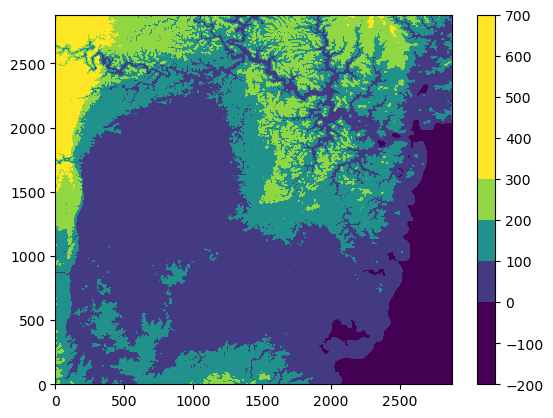

In [6]:
band1 = dataset.GetRasterBand(1)
novalue = band1.GetNoDataValue()

print(novalue)

b1 = band1.ReadAsArray()

b1 = np.flipud(b1)
plt.figure()

ax = plt.axes()
#ax.set_global()

#plt.imshow(b1)
plt.contourf(b1, vmax=300, vmin=0.0)
#plt.contour(b1, colors = 'black', #cmap = "Grey", 
#            levels = [0.0, 2000]) #list(range(1, 3, 1)))
#ax.coastlines()
plt.colorbar()
plt.show()

In [ ]:
make_a_utm_tif(south=False)
make_a_ll_tif()

In [ ]:
ls

In [ ]:
from anuga.file_conversion.tif2array import  tif2array
from anuga.file_conversion.tif2point_values import tif2point_values

In [ ]:
from pprint import pprint
x,y,Z = tif2array('PointData_test_utm.tif')
print(x.shape, y.shape, Z.shape)
pprint(Z[11,:])
pprint(y)
pprint(x)

In [ ]:
x = numpy.linspace(307000., 308000., 11)
y = numpy.linspace(6193000., 6194000., 11)
xG, yG = numpy.meshgrid(x, y)
xG = xG.flatten()
yG = yG.flatten()


points = numpy.vstack((xG,yG)).T
Z = tif2point_values('PointData_test_ll.tif', zone=56, south=True, points = points)
print(Z.shape)
print(min(Z),max(Z))
import pprint
pprint.pprint(Z)

In [ ]:
import utm



In [ ]:
lat, lon = utm.to_latlon(x,y,zone_number=56, northern=False)
print(lat)
print(lon)

In [ ]:
lat, lon = utm.to_latlon(x,y,zone_number=56, northern=True)
print(lat)
print(lon)

In [ ]:
y

In [ ]:
lat, lon = utm.to_latlon(500_000,-4_000_000,zone_number=56, northern=True, strict=False)
print(lat)
print(lon)

In [ ]:
lat, lon = utm.to_latlon(500_000,6_000_000,zone_number=56, northern=False)
print(lat)
print(lon)

In [ ]:
lat_ll, lon_ll = -34.39, 150.90
lat_ur, lon_ur = -34.37, 150.92

import utm
utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll = utm.from_latlon(lat_ll, lon_ll)
utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur = utm.from_latlon(lat_ur, lon_ur)

print(utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll)
print(utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur)

In [ ]:
def zone_letter_to_hemisphere(zone_letter):
    hemisphere = 'undefined'
    if zone_letter.lower() in 'cdefghjklm':
        hemisphere = 'southern'
    if zone_letter.lower() in 'npqrstuvwx':
        hemisphere = 'northern'
    return hemisphere
        

In [ ]:
zone_letter_to_hemisphere(zone_dd_ll)